## **EE5180: Laboratory Session-3: Perceptron & Multi_Layer Perceptron (MLP)**

Agenda:
1. Single Layer Perceptron for Linear Separable Data
2. AND, OR Implementation using Single Layer Perceptron 
3. XOR Implementation using Multi Layer Perceptron (MLP)
4. Digit Classification with MNIST Data using MLP

### **1. Single Layer Perceptron for Linear Separable Data**

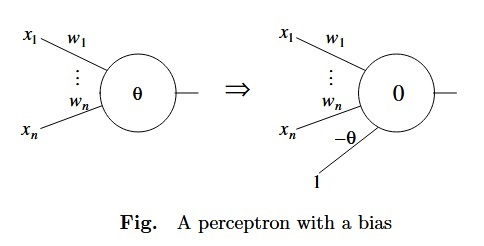

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/EE5180_MLLab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/EE5180_MLLab


Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

Prepare a toy dataset: Dataset.txt

In [ ]:

data = np.genfromtxt('Dataset.txt', delimiter='\t')
x, y = data[:, :2], data[:, 2]    #x: features, y: labels
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('x.shape:', x.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
x, y = x[shuffle_idx], y[shuffle_idx]

x_train, x_test = x[shuffle_idx[:70]], x[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = x_train.mean(axis=0), x_train.std(axis=0)
x_train = (x_train - mu) / sigma
x_test = (x_test - mu) / sigma

Class label counts: [50 50]
x.shape: (100, 2)
y.shape: (100,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


Plot Training Data

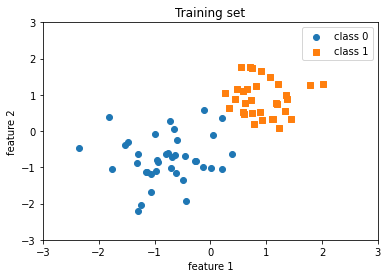

In [ ]:
plt.scatter(x_train[y_train==0, 0], x_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(x_train[y_train==1, 0], x_train[y_train==1, 1], label='class 1', marker='s')
plt.title('Training set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

Plot Test Data

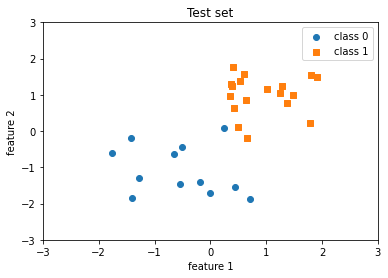

In [ ]:
plt.scatter(x_test[y_test==0, 0], x_test[y_test==0, 1], label='class 0', marker='o')
plt.scatter(x_test[y_test==1, 0], x_test[y_test==1, 1], label='class 1', marker='s')
plt.title('Test set')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend()
plt.show()

Define the Perceptron Model and its Training Rule

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)
        
        # placeholder vectors so they don't
        # need to be recreated each time
        self.ones = torch.ones(1)
        self.zeros = torch.zeros(1)

    def forward(self, x):
        linear = torch.mm(x, self.weights) + self.bias
        predictions = torch.where(linear > 0., self.ones, self.zeros)
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.shape[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].reshape(1, self.num_features), y[i]).reshape(-1)
                self.weights += (errors * x[i]).reshape(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).reshape(-1)
        accuracy = torch.sum(predictions == y).float() / y.shape[0]
        return accuracy

Training and Testing the Perceptron

In [ ]:
#TRAINING
ppn = Perceptron(num_features=2)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(x_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

#TESTING
x_test_tensor = torch.tensor(x_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(x_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Model parameters:
  Weights: tensor([[1.2734],
        [1.3464]])
  Bias: tensor([-1.])
Test set accuracy: 93.33%


Plot the Decision Boundary

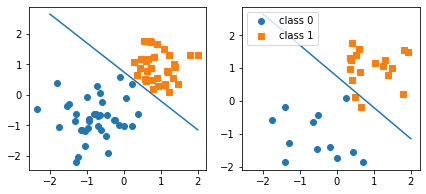

In [ ]:
w, b = ppn.weights, ppn.bias

x0_min = -2
x1_min = ( (-(w[0] * x0_min) - b[0]) 
          / w[1] )

x0_max = 2
x1_max = ( (-(w[0] * x0_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x0_min, x0_max], [x1_min, x1_max])
ax[1].plot([x0_min, x0_max], [x1_min, x1_max])

ax[0].scatter(x_train[y_train==0, 0], x_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(x_train[y_train==1, 0], x_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(x_test[y_test==0, 0], x_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(x_test[y_test==1, 0], x_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

**-----------------End of Part-I---------------**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ML_Demo_9922

/content/drive/MyDrive/ML_Demo_9922


In [ ]:
!ls

data  data.csv	weights.pth


## **3. AND OR XOR Implementation using MLP**

# **The rule**
The output node has a "threshold" t.

Rule: If summed input ≥ t, then it "fires" (output y = 1).

Else (summed input < t) it doesn't fire (output y = 0).



# **Perceptron for XOR:**
XOR is where if one is 1 and other is 0 but not both.

Need:
1.w1 + 0.w2 cause a fire, i.e. >= t

0.w1 + 1.w2 >= t

0.w1 + 0.w2 doesn't fire, i.e. < t

1.w1 + 1.w2 also doesn't fire, < t


w1 >= t

w2 >= t

0 < t

w1+w2 < t

Contradiction.

In [ ]:
#import libraries 
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [ ]:
# create data
Xs = torch.Tensor([[0., 0.],
               [0., 1.],
               [1., 0.],
               [1., 1.]])

y = torch.Tensor([0., 1., 1., 0.]).reshape(Xs.shape[0], 1)

Design the XOR model using Neural Network module of Torch

In [ ]:
class XOR(nn.Module):
    def __init__(self):
        super(XOR, self).__init__()
        self.linear1 = nn.Linear(2, 2)    #linear (m,n) Creates a neurons with m inputs and n outputs
        self.Sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(2, 1)
        self.Sigmoid2 = nn.Sigmoid()

    def forward(self, input):
      x = self.linear1(input)
      sig = self.Sigmoid(x)
      x2 = self.linear2(sig)
      sig2 = self.Sigmoid2(x2)
      
      return sig2

In [ ]:
xor_network = XOR()

In [ ]:
epochs = 1000
#loss_fn = nn.CrossEntropyLoss()
loss_fn= nn.MSELoss()
optimizer = torch.optim.Adam(xor_network.parameters(), lr = 0.03)
all_losses = []
current_loss = 0
plot_every = 50

for epoch in range(epochs):

  # input training example and return the prediction
  yhat = xor_network.forward(Xs)

  # calculate MSE loss
  loss = loss_fn(yhat, y)
  
  # backpropogate through the loss gradiants
  loss.backward()

  # update model weights
  optimizer.step()

  # remove current gradients for next iteration
  optimizer.zero_grad()

  # append to loss
  current_loss += loss
  if epoch % plot_every == 0:
      all_losses.append(current_loss / plot_every)
      #print(current_loss)
      current_loss = 0
  
  # print progress
  if epoch % 500 == 0:
    print(f'Epoch: {epoch} completed')

Epoch: 0 completed
Epoch: 500 completed


In [ ]:
#xor_network.load_state_dict(torch.load('/content/drive/MyDrive/ML_Demo_9922/weights.pth'))

FileNotFoundError: ignored

In [ ]:
# show weights and bias
w=[]
for name, param in xor_network.named_parameters():
    if param.requires_grad:
        w.append(param.data)
        print(name, param.data)

linear1.weight tensor([[ 6.7010, -6.6896],
        [-6.8702,  6.6570]])
linear1.bias tensor([-3.7398, -3.6889])
linear2.weight tensor([[8.3771, 8.3984]])
linear2.bias tensor([-4.1565])


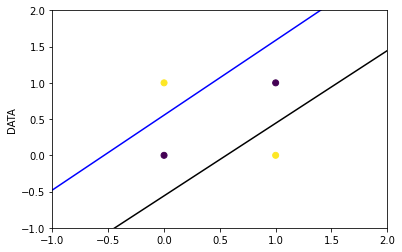

In [ ]:
import matplotlib.pyplot as plt
xp=torch.tensor(np.linspace(-1,2,4))
#yp=-(xp*w[0][0][0]+w[1][0])/w[0][0][1]
yp1=-(xp*w[0][0][0]+w[1][0])/w[0][0][1]
yp2=-(xp*w[0][1][0]+w[1][1])/w[0][1][1]
yp3=-(xp*w[2][0][0]+w[3])/w[2][0][1]

plt.scatter(Xs[:,0], Xs[:,1],c=y)
#plt.plot(xp,yp,'m')
plt.plot(xp,yp1,'k')
plt.plot(xp,yp2,'b')
#plt.plot(xp,yp3,'r')
plt.ylabel('DATA')
plt.xlim([-1, 2])
plt.ylim([-1, 2])
plt.show()



In [ ]:
print(yp2)

tensor([ 1.4576,  0.4563, -0.5450, -1.5463], dtype=torch.float64)


In [ ]:
# test input
x=[[0., 0.],[0.,1.],[1.,0.],[1.,1.]]
input = torch.tensor(x)
out = xor_network(input)
print(out.round())

tensor([[0.0220],
        [0.9796],
        [0.9797],
        [0.0193]], grad_fn=<SigmoidBackward0>)


In [ ]:
torch.save(xor_network.state_dict(), '/content/sample_data/weights.pth')

**--------------End of Part-III------------**

# Multi-Layer Perceptron, MNIST
---
In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [ ]:
# import libraries
import torch
import numpy as np

---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

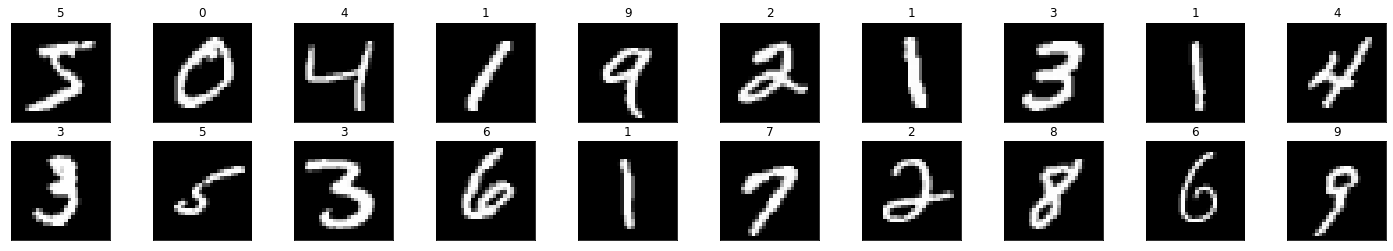

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

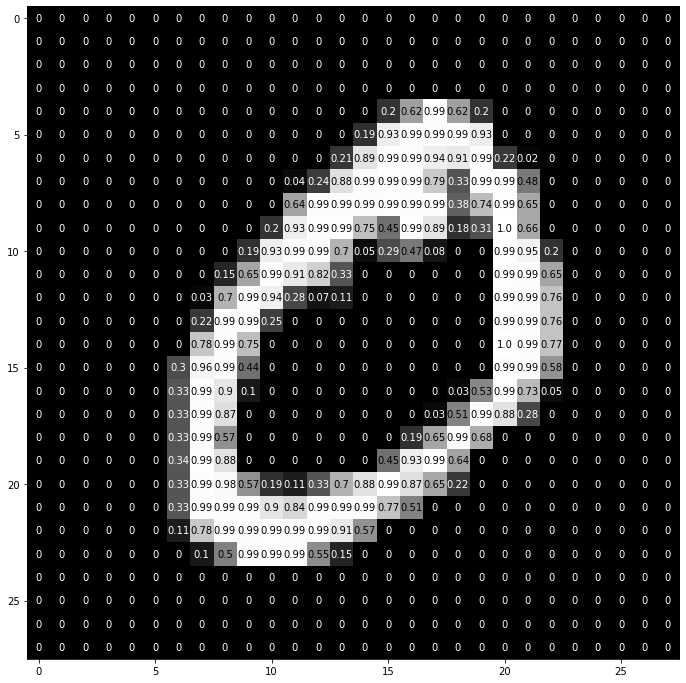

In [ ]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

## Define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(512, 512)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(512, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [ ]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 30 epochs; feel free to change this number. For now, we suggest somewhere between 20-50 epochs. As you train, take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data. 

In [ ]:
# number of epochs to train the model
n_epochs = 30  # suggest training between 20-50 epochs

model.train() # prep model for training

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.791651
Epoch: 2 	Training Loss: 0.411622
Epoch: 3 	Training Loss: 0.370094
Epoch: 4 	Training Loss: 0.349025
Epoch: 5 	Training Loss: 0.335589
Epoch: 6 	Training Loss: 0.326019
Epoch: 7 	Training Loss: 0.318735
Epoch: 8 	Training Loss: 0.312940
Epoch: 9 	Training Loss: 0.308181
Epoch: 10 	Training Loss: 0.304176
Epoch: 11 	Training Loss: 0.300741
Epoch: 12 	Training Loss: 0.297750
Epoch: 13 	Training Loss: 0.295113
Epoch: 14 	Training Loss: 0.292762
Epoch: 15 	Training Loss: 0.290647
Epoch: 16 	Training Loss: 0.288731
Epoch: 17 	Training Loss: 0.286983
Epoch: 18 	Training Loss: 0.285379
Epoch: 19 	Training Loss: 0.283899
Epoch: 20 	Training Loss: 0.282527
Epoch: 21 	Training Loss: 0.281251
Epoch: 22 	Training Loss: 0.280059
Epoch: 23 	Training Loss: 0.278942
Epoch: 24 	Training Loss: 0.277891
Epoch: 25 	Training Loss: 0.276901
Epoch: 26 	Training Loss: 0.275966
Epoch: 27 	Training Loss: 0.275079
Epoch: 28 	Training Loss: 0.274238
Epoch: 29 	Training Loss: 0.2

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for *evaluation*

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.274017

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 97% (1109/1135)
Test Accuracy of     2: 89% (919/1032)
Test Accuracy of     3: 90% (914/1010)
Test Accuracy of     4: 92% (910/982)
Test Accuracy of     5: 87% (781/892)
Test Accuracy of     6: 94% (908/958)
Test Accuracy of     7: 92% (946/1028)
Test Accuracy of     8: 88% (864/974)
Test Accuracy of     9: 90% (915/1009)

Test Accuracy (Overall): 92% (9228/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

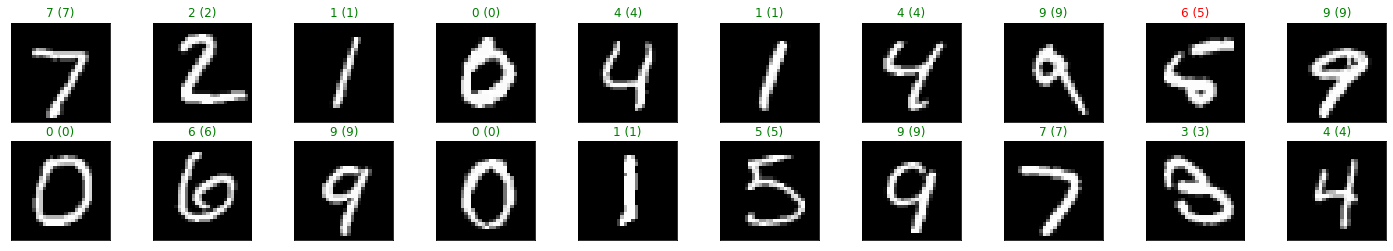

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))